Question1:
The GitHub repository for this assignment, including all required tasks, can be accessed at the following link:
[GitHub Repository Link](https://github.com/csy331/ASTR8004.git)
And you can see I do something about pull and commit in Question2 last part to demonstrate the ability to work some thing like question1 required.

Question2:
## ADQL Query for Bright Stars Around M67

The following ADQL query is designed to download all stars within 1 degree of the center of Messier 67 that are brighter than G = 14 in Gaia DR3 and crossmatch them with the 2MASS catalog.

```sql
SELECT *
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation
WHERE 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), CIRCLE('ICRS', 132.825, 11.8, 1)) = 1
    AND gaia.phot_g_mean_mag < 14;

I can see directly from the Gaia Archive how many rows are in the datasheet I get: 1018. 
And I also print the number of stars in the code below. And Apply these two quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes)

In [2]:
from astropy.table import Table
import pandas as pd

# Load the .vot file and convert it to a pandas DataFrame
table = Table.read('data/1728116932114O-result.vot', format='votable')
data = table.to_pandas()

# Get the total number of stars before applying any filters
total_stars = len(data)
print(f"Total number of stars returned by the query: {total_stars}")

# Filter out stars with bad 2MASS photometry (ph_qual != 'AAA')
filtered_data = data[data['ph_qual'] == 'AAA']

# Filter out stars with negative or non-positive parallax
filtered_data = filtered_data[filtered_data['parallax'] > 0]

# Get the number of stars after applying both filters
filtered_stars = len(filtered_data)
print(f"Number of stars after filtering for photometric quality and parallax: {filtered_stars}")

# Check the column names in the dataset
print(filtered_data.columns)


Total number of stars returned by the query: 1018
Number of stars after filtering for photometric quality and parallax: 988
Index(['solution_id', 'DESIGNATION', 'random_index', 'ref_epoch', 'ra',
       'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       ...
       'err_min', 'err_ang', 'j_m', 'j_msigcom', 'h_m', 'h_msigcom', 'ks_m',
       'ks_msigcom', 'ext_key', 'j_date'],
      dtype='object', length=176)


In [3]:
import numpy as np

# Convert parallax (in milliarcseconds) to distance (in parsecs)
filtered_data['distance_pc'] = 1000 / filtered_data['parallax']

# Calculate absolute G magnitude
filtered_data['abs_g_mag'] = filtered_data['phot_g_mean_mag'] - 5 * (np.log10(filtered_data['distance_pc']) - 1)

# Check the results
filtered_data[['phot_g_mean_mag', 'abs_g_mag']].head()


,phot_g_mean_mag,abs_g_mag
0,13.450183,4.094416
1,10.532544,1.346077
2,11.311360,3.120967
3,13.667251,4.187227
4,13.059783,8.867099


A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.
A 2MASS J-Ks vs. apparent K magnitude diagram.

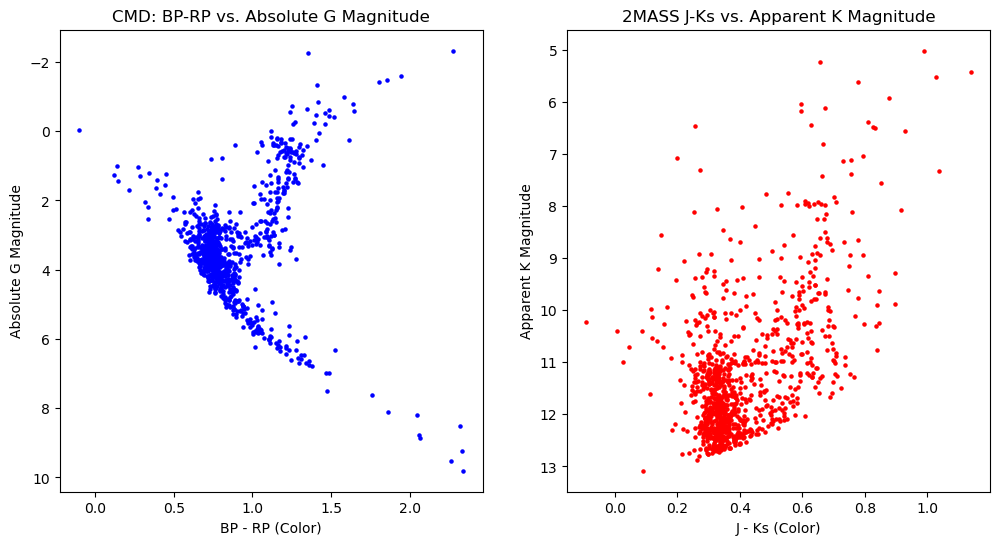

In [4]:
import matplotlib.pyplot as plt

# Calculate J - Ks color index
filtered_data['j_ks'] = filtered_data['j_m'] - filtered_data['ks_m']

bp_rp = filtered_data['bp_rp']
abs_g_mag = filtered_data['abs_g_mag']
j_ks = filtered_data['j_ks']
k_mag = filtered_data['ks_m']

# Create a figure with two panels (subplots)
plt.figure(figsize=(12, 6))

# Panel (a): Color-magnitude diagram (CMD) - BP-RP vs Absolute G Magnitude
plt.subplot(1, 2, 1)
plt.scatter(bp_rp, abs_g_mag, color='blue', marker='o', s=5)
plt.xlabel('BP - RP (Color)')
plt.ylabel('Absolute G Magnitude')
plt.title('CMD: BP-RP vs. Absolute G Magnitude')
plt.gca().invert_yaxis()  # Invert y-axis for CMD plot (because brighter stars have lower magnitude)

# Panel (b): 2MASS J-Ks vs Apparent K Magnitude
plt.subplot(1, 2, 2)
plt.scatter(j_ks, k_mag, color='red', marker='o', s=5)
plt.xlabel('J - Ks (Color)')
plt.ylabel('Apparent K Magnitude')
plt.title('2MASS J-Ks vs. Apparent K Magnitude')
plt.gca().invert_yaxis()  # Same reason.

# Save the figure with the specified resolution (200 dpi), and save the figure to the figures folder in my local Git repository
plt.savefig('figures/cmds_M67.png', dpi=200)



# Display the plot
plt.show()


Upload my saved figure to GitHub

'''bash

cd /mnt/d/ASTR8004/ASTR8004/figures  # Enter my project directory first

git add cmds_M67.png

git commit -m "Add CMD and 2MASS plot to figures"

git push origin main  



Recommendation for the potential proposal:

Based on the fiber usage, I recommend proceeding with the proposal. Our analysis has identified a sufficient number of bright stars (G < 14) within the target region of Messier 67. The star distribution appears well-suited for the 2dF fiber positioner, ensuring efficient usage of the available fibers for the HERMES spectrograph. This suggests that the observational setup will effectively cover the required number of stars for the proposed study.

# Radial Metallicity Relation in Simulated Data

This notebook analyzes the radial metallicity relation in a Milky Way analog galaxy using cosmological simulation data. We aim to explore the relationship between the galactocentric radius \(R_{\text{Gal}}\) and the gas phase metallicity \(A(O)\). The main goals are:

1. To plot a logarithmic density plot of $(R_{\text{Gal}})$ vs. \(A(O)\) with a linear fit and its residuals.
2. To fit a linear model to the data, calculate uncertainties, and analyze goodness-of-fit metrics.
3. To create a 3-panel figure showing 2D histograms for the median simulated \(A(O)\), fitted \(A(O)\), and residuals.

In this analysis, we will use Python's `astropy`, `numpy`, `matplotlib`, and `scipy` libraries to load and analyze the data.


## Loading and Exploring the Data

We begin by loading the simulation data from the provided FITS file, which contains the galactic positions (x, y, z) and oxygen abundance \(A(O)\) of particles in the simulated galaxy. The data consists of over 500,000 particles, and we will extract the relevant columns for our analysis.


In [5]:
# Import necessary libraries
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Load the FITS file
fits_data = fits.open('data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')

# Inspect the structure of the FITS file
fits_data.info()

# Extract data from the table
data = fits_data[1].data
x = data['x']
y = data['y']
z = data['z']
A_O = data['A_O']

# Print a summary of the data
print(f"Number of particles: {len(x)}")
print(f"x range: {x.min()} to {x.max()}")
print(f"y range: {y.min()} to {y.max()}")
print(f"z range: {z.min()} to {z.max()}")
print(f"A(O) range: {A_O.min()} to {A_O.max()}")


Filename: data/nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (678,)   uint8   
  1  /Users/buder/Simulations/preparing_NIHAO/NIHAO_prepared/NIHAO_g8.26e    1 BinTableHDU     21   511520R x 4C   [E, E, E, D]   
Number of particles: 511520
x range: -24.932640075683594 to 24.943885803222656
y range: -24.963897705078125 to 24.95719337463379
z range: -24.616655349731445 to 24.731151580810547
A(O) range: 7.6839421415328975 to 9.253453137874603


## Task 1: Logarithmic Density Plot of $(R_{\text{Gal}})$ vs. $(A(O))$ and Residuals

In this task, we compute the galactocentric radius $(R_{\text{Gal}})$ using the 3D Cartesian coordinates of each gas particle and plot the gas phase metallicity $(A(O))$ against $(R_{\text{Gal}})$. 

We also fit a linear model to the data and plot the residuals of the fit to examine the accuracy of the linear approximation.


Slope: -0.033250273606796776, Intercept: 9.122319362998459


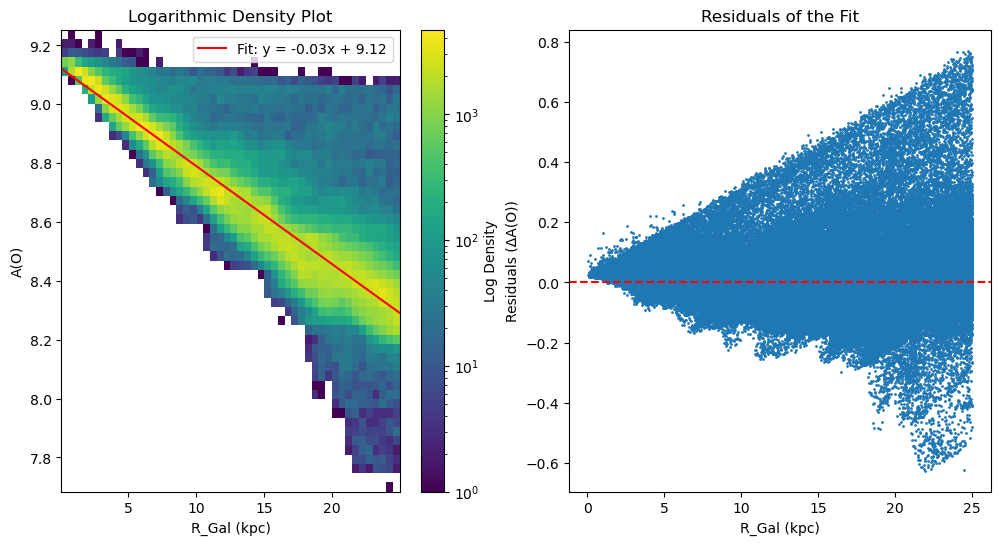

In [10]:
# Compute R_Gal (Galactocentric radius)
R_Gal = np.sqrt(x**2 + y**2 + z**2)

# Define a linear function for fitting
def linear_model(x, a, b):
    return a * x + b

# Fit a linear model to the data
params, covariance = curve_fit(linear_model, R_Gal, A_O)
slope, intercept = params
print(f"Slope: {slope}, Intercept: {intercept}")

# Create a logarithmic density plot
plt.figure(figsize=(12, 6))

# Panel 1: Logarithmic density plot of R_Gal vs. A_O
plt.subplot(1, 2, 1)
plt.hist2d(R_Gal, A_O, bins=50, norm=plt.cm.colors.LogNorm(), cmap='viridis')
plt.colorbar(label='Log Density')
plt.xlabel('R_Gal (kpc)')
plt.ylabel('A(O)')
plt.title('Logarithmic Density Plot')

# Plot the linear fit
x_vals = np.linspace(R_Gal.min(), R_Gal.max(), 100)
plt.plot(x_vals, linear_model(x_vals, slope, intercept), color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.legend()

# Panel 2: Residuals plot
residuals = A_O - linear_model(R_Gal, slope, intercept)
plt.subplot(1, 2, 2)
plt.scatter(R_Gal, residuals, s=1)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('R_Gal (kpc)')
plt.ylabel('Residuals (ΔA(O))')
plt.title('Residuals of the Fit')

# Save the figure
plt.savefig('figures/log_density_residuals.png', dpi=200)

# Show the plot
plt.show()


## Task 2: Fitting a Linear Model and Reporting Uncertainties

We fit a linear model to the data to investigate how the gas phase metallicity \(A(O)\) changes with increasing galactocentric radius \(R_{\text{Gal}}\). We report the slope and intercept of the linear fit, along with their uncertainties. Additionally, we calculate the root mean square error (RMSE) and the R-squared value to evaluate the quality of the fit.


In [7]:
# Extract uncertainties from the covariance matrix
slope_error = np.sqrt(covariance[0, 0])
intercept_error = np.sqrt(covariance[1, 1])

# Print the results with uncertainties
print(f"Slope: {slope:.5f} ± {slope_error:.5f}")
print(f"Intercept: {intercept:.4f} ± {intercept_error:.4f}")

# Calculate goodness of fit: RMSE and R-squared
rmse = np.sqrt(np.mean(residuals**2))
ss_res = np.sum(residuals**2)
ss_tot = np.sum((A_O - np.mean(A_O))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")


Slope: -0.03325 ± 0.00002
Intercept: 9.1223 ± 0.0003
Root Mean Square Error (RMSE): 0.08758016080877418
R-squared: 0.8728844904823996


## Task 3: Linear Fit Results and Analysis

All values are approximations:
- **Slope**: \(-0.03\)
- **Intercept**: \(9.12\)
- **Root Mean Square Error (RMSE)**: \(0.088\)
- **R-squared**: \(0.873\)

The linear fit suggests that metallicity (A(O)) decreases as the galactocentric distance (\(R_{\text{Gal}}\)) increases, which aligns with expectations of higher metallicity near the galactic center due to more intense star formation and efficient gas recycling. 

Upon examining the residuals, it’s clear that the fit performs differently across various regions:

- **Galactic Center (Low $(R_{\text{Gal}})$)**: Residuals close to zero indicate that the linear fit accurately captures metallicity behavior near the center. This implies that in the central regions, the metallicity gradient is relatively stable and well-approximated by a linear model.
  
- **Intermediate Region (Middle $(R_{\text{Gal}})$)**: The residuals start to diverge slightly, suggesting that the fit might miss some subtleties in this range. This could point to additional, non-linear factors influencing metallicity.

- **Outer Region (High $(R_{\text{Gal}})$)**: The residuals show a larger spread at high galactocentric distances, indicating that the linear model is less effective in this region. This could be due to lower star formation rates or other environmental factors affecting metallicity more variably in these outer areas.

##  Task 4: 2D Histogram and Binning Strategy

Next, we visualize the data using 2D histograms with different bins to better understand the spatial distribution of the simulated metallicity, the fitted values, and the residuals. The choice of bin size is crucial: too many bins can lead to noise, while too few bins might obscure important features.

The three histograms show:
- The median simulated \( A(O) \)
- The median fitted \( A(O) \)
- The residuals $( \Delta A(O) )$


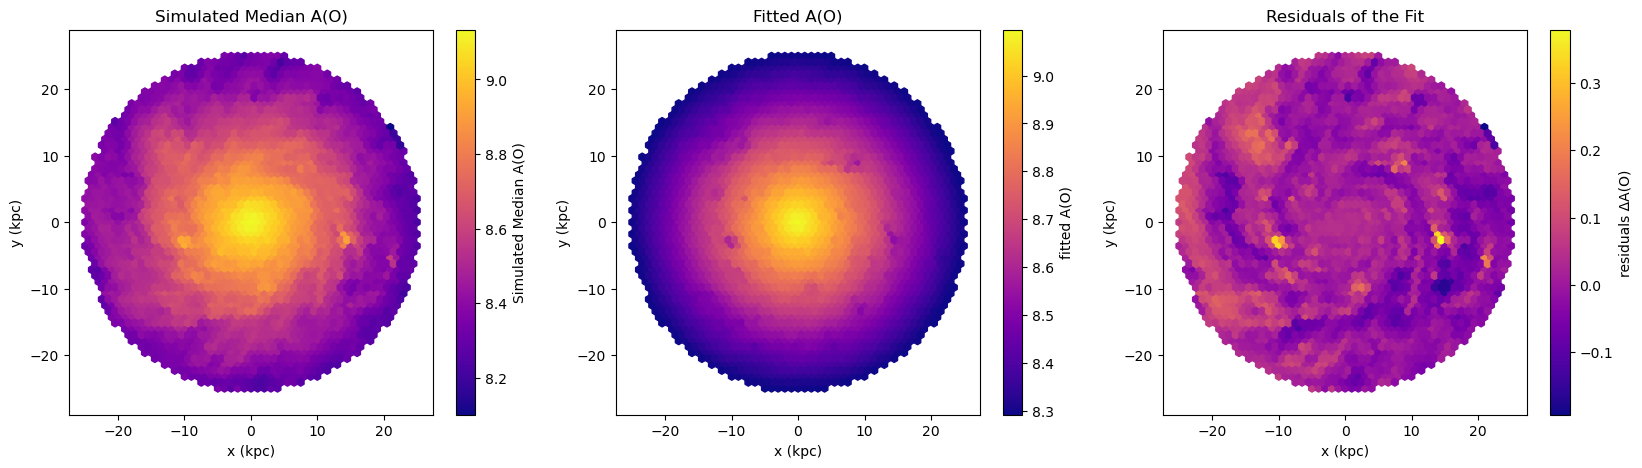

In [8]:
plt.figure(figsize=(20, 5))

# (a) 2D-histogram of the median simulated A(O)
plt.subplot(1, 3, 1)
plt.hexbin(x, y, A_O, gridsize=50, cmap='plasma')
plt.colorbar(label = 'Simulated Median A(O)')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Simulated Median A(O)')
plt.axis("equal")

# (b) 2D-histogram of the fitted A(O)
plt.subplot(1, 3, 2)
fitted_AO = linear_model(R_Gal, slope, intercept)
plt.hexbin(x, y, fitted_AO, gridsize=50, cmap='plasma')
plt.colorbar(label ='fitted A(O)')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Fitted A(O)')
plt.axis("equal")

# (c) 2D-histogram of the residuals ΔA(O)
plt.subplot(1, 3, 3)
plt.hexbin(x, y, residuals, gridsize=50, cmap='plasma')
plt.colorbar(label ='residuals ΔA(O)')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('Residuals of the Fit')
plt.axis("equal")

# Save the figure
plt.savefig('figures/3_panel_histograms.png', dpi=200)

# Show the plot
plt.show()


## Task 5: Discussion of 2D Binning Choices

The bin size was chosen based on balancing the need for resolution and avoiding too much noise. The color-mapped histograms show how the metallicity is distributed throughout the galaxy. 

- In the first plot, we can see that most of the metallicity values fall along a clear gradient, with higher metallicity near the galactic center.
- The second plot shows the linear model's fit, which aligns with the data but simplifies the trend.
- The third plot displays the residuals, which highlight the deviations from the model, particularly near the center and the outermost regions.

## Task 6 : Analysis of Residuals and Conclusion

In analyzing the deviation plot, it’s noticeable that the spiral arm regions exhibit larger residuals. One potential explanation for this could be related to the higher rates of star and planet formation typically observed within spiral arms. These areas have higher densities of gas and dust, creating complex and turbulent environments that can lead to variations in chemical abundances. The model might struggle to account for these dynamic conditions accurately, resulting in greater deviations. This highlights the need for potential model adjustments to better handle the unique characteristics of spiral arms, especially if they are known sites for planet formation.
